# HW3 Analysis

## Import and load data

In [1]:
import ml_pipeline as pp
import pandas as pd
import datetime as dt
import numpy as np
#from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
file = './data/projects_2012_2013.csv'
df = pp.load_csv(file)

## Data transformations

### Helper functions for hw3 specific data

#### Convert date columns to datetime

In [3]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded'],
      dtype='object')

In [4]:
df.date_posted = pp.col_datetime(df, 'date_posted')

In [5]:
df.datefullyfunded = pp.col_datetime(df,'datefullyfunded')

#### Create labels: 1 if not fully funded in 60 days, 0 if fully funded in 60 days

In [6]:
df = pp.create_label(df, pred_time=60)

## Run variations of models: 
### Decision trees, KNN, Logistic Regression, Linear SVM, Random forests, Bagging, Boosting

In [7]:
windows = [dt.datetime(2012,1,1), dt.datetime(2012,7,1), dt.datetime(2013,1,1), dt.datetime(2013,7,1), dt.datetime(2014,1,1)]
pred_time = 60 #days
start_index = 1
label_col = 'label'
split_col = 'date_posted'
feature_cols= [x for x in df.columns if x not in ['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'date_posted', 'datefullyfunded', 'label']]
impute_info = ((pp.most_freq, ['school_metro','primary_focus_subject','primary_focus_area','resource_type','grade_level']), (np.nanmedian,['students_reached']))
bucketdict= {'total_price_including_optional_support': (4, ('lowest', 'low', 'medium', 'high')), 'students_reached':(4, ('lowest', 'low', 'medium', 'high'))}
top_k = {'school_state':30, 'school_city':30,'school_district':30, 'school_county':30}
seed=12345
thresholds = [1, 2, 5, 10, 20,30, 50]

In [8]:
models = [
    {'type': 'Dtree', 'clf': DecisionTreeClassifier(), 'params': {'criterion': ['entropy', 'gini'], 'max_depth': [10,20,30],'min_samples_split': [100, 300,500], 'random_state': [seed]}},
    {'type': 'LR', 'clf': LogisticRegression(), 'params':{'penalty': ['l1','l2'], 'C': [0.1, 1.0, 10.0, 100.0], 'solver': ['liblinear'], 'random_state': [seed]}},
    {'type': 'SVM', 'clf': LinearSVC(), 'params':{'penalty': ['l2'], 'C': [0.1, 1.0, 10.0, 100.0], 'random_state': [seed]}},
    {'type': 'Bagging_dtree', 'clf': BaggingClassifier(), 'params':{'n_estimators': [100, 500, 1000], 'base_estimator':[None], 'random_state':[seed], 'n_jobs':[5]}},
    {'type': 'ADABoost_dtree', 'clf': AdaBoostClassifier(), 'params':{'n_estimators': [100, 500, 1000], 'base_estimator':[None], 'random_state':[seed]}},
    {'type': 'GBoost', 'clf': GradientBoostingClassifier(), 'params': {'n_estimators': [100, 500, 1000], 'min_samples_split': [100, 300,500], 'random_state':[seed]}},
    {'type': 'ExtraTrees', 'clf': ExtraTreesClassifier(),'params': {'n_estimators': [100, 500, 1000], 'criterion': ['entropy', 'gini'],'min_samples_split': [100, 300,500], 'max_depth': [10,20,30],'random_state':[seed], 'n_jobs':[5]}},
    {'type': 'Random Forest', 'clf': RandomForestClassifier(), 'params':{'n_estimators': [100, 500, 1000], 'criterion': ['entropy', 'gini'], 'random_state': [seed]}},
    {'type': 'Random Forest', 'clf': RandomForestClassifier(), 'params':{'n_estimators': [100, 500, 1000], 'criterion': ['entropy', 'gini'], 'random_state': [seed], 'n_jobs':[5]}},
    {'type': 'KNN', 'clf': KNeighborsClassifier(), 'params':{'n_neighbors': [5,7], 'weights': ['uniform','distance'], 'metric':['minkowski'],'p': [1,2], 'n_jobs': [4]}},
    {'type': 'NB', 'clf': GaussianNB(),'params':{'priors':[None]}}
]


In [9]:
#this code was run separately and saved in csv for future use, but this is how it is run
resdf=pp.run_models(models, thresholds, windows, start_index, df, feature_cols, label_col, split_col, impute_info, bucketdict, top_k, pred_time, pred_unit = 'day', filename = './data/finalrun')


Dtree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 100, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 300, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 500, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 100, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 300, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 500, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 300, 'random_state': 12345}
Dtree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 500, 'random_state': 12345}
Dtree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 100, 'random_state': 12345}
Dtree: {'criterion': 'g

KeyboardInterrupt: 

In [13]:
resdf = pp.load_csv('./data/finalrun.csv')
resdf.shape

(2359, 10)

## Comparing model results

#### Start by finding models with highest precision, recall, or auc.

##### Models have the highest percision at a threshold of 1%

In [14]:
resdf.sort_values('precision', ascending=False)

,type,details,baseline,threshold_pct,precision,recall,auc,train_set_num,train_start,test_start
1729,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.284647,1,0.633484,0.022272,0.508572,3,1/1/12,7/1/13
994,SVM,"{'random_state': 12345, 'C': 10.0, 'penalty': ...",0.315889,1,0.631336,0.019980,0.507296,2,1/1/12,1/1/13
1736,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.284647,1,0.631222,0.022192,0.508517,3,1/1/12,7/1/13
1743,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.284647,1,0.628959,0.022113,0.508461,3,1/1/12,7/1/13
1778,SVM,"{'random_state': 12345, 'penalty': 'l2', 'C': ...",0.284647,1,0.626697,0.022033,0.508405,3,1/1/12,7/1/13
1827,ADABoost_dtree,"{'n_estimators': 500, 'base_estimator': None, ...",0.284647,1,0.624434,0.021954,0.508350,3,1/1/12,7/1/13
1785,SVM,"{'random_state': 12345, 'penalty': 'l2', 'C': ...",0.284647,1,0.624434,0.021954,0.508350,3,1/1/12,7/1/13
2198,ExtraTrees,"{'max_depth': 30, 'n_jobs': 10, 'n_estimators'...",0.284647,1,0.624434,0.021954,0.508350,3,1/1/12,7/1/13
2002,ExtraTrees,"{'max_depth': 30, 'n_jobs': 10, 'n_estimators'...",0.284647,1,0.624434,0.021954,0.508350,3,1/1/12,7/1/13
1771,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.284647,1,0.622172,0.021874,0.508294,3,1/1/12,7/1/13


##### Models have the highest recall at a threshold of 50%

In [15]:
resdf.sort_values('recall', ascending=False)

,type,details,baseline,threshold_pct,precision,recall,auc,train_set_num,train_start,test_start
1021,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 500, '...",0.315889,50,0.323936,0.512761,0.509310,2,1/1/12,1/1/13
979,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,50,0.323936,0.512761,0.509310,2,1/1/12,1/1/13
972,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,50,0.323936,0.512761,0.509310,2,1/1/12,1/1/13
965,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,50,0.323936,0.512761,0.509310,2,1/1/12,1/1/13
958,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,50,0.323936,0.512761,0.509310,2,1/1/12,1/1/13
1014,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 100, '...",0.315889,50,0.323752,0.512469,0.509096,2,1/1/12,1/1/13
951,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,50,0.323752,0.512469,0.509096,2,1/1/12,1/1/13
1077,GBoost,"{'random_state': 12345, 'min_samples_split': 3...",0.315889,50,0.323752,0.512469,0.509096,2,1/1/12,1/1/13
1000,SVM,"{'random_state': 12345, 'C': 10.0, 'penalty': ...",0.315889,50,0.323752,0.512469,0.509096,2,1/1/12,1/1/13
1098,GBoost,"{'random_state': 12345, 'min_samples_split': 5...",0.315889,50,0.323659,0.512323,0.508990,2,1/1/12,1/1/13


##### Bagging decision trees have the highest AUC

In [16]:
aucdf = resdf.sort_values('auc', ascending=False)
aucdf

,type,details,baseline,threshold_pct,precision,recall,auc,train_set_num,train_start,test_start
1013,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 100, '...",0.315889,30,0.332924,0.316173,0.511824,2,1/1/12,1/1/13
1020,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 500, '...",0.315889,30,0.332770,0.316027,0.511717,2,1/1/12,1/1/13
1496,Random Forest,"{'random_state': 12345, 'criterion': 'entropy'...",0.315889,30,0.332463,0.315736,0.511504,2,1/1/12,1/1/13
978,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,30,0.332310,0.315590,0.511398,2,1/1/12,1/1/13
1524,Random Forest,"{'random_state': 12345, 'criterion': 'gini', '...",0.315889,30,0.332310,0.315590,0.511398,2,1/1/12,1/1/13
971,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,30,0.332310,0.315590,0.511398,2,1/1/12,1/1/13
964,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.315889,30,0.332310,0.315590,0.511398,2,1/1/12,1/1/13
1468,ExtraTrees,"{'n_jobs': 5, 'max_depth': 30, 'random_state':...",0.315889,30,0.332156,0.315444,0.511291,2,1/1/12,1/1/13
1027,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 1000, ...",0.315889,30,0.332156,0.315444,0.511291,2,1/1/12,1/1/13
999,SVM,"{'random_state': 12345, 'C': 10.0, 'penalty': ...",0.315889,30,0.332156,0.315444,0.511291,2,1/1/12,1/1/13


In [17]:
aucdf.groupby(['train_set_num']).first()

,type,details,baseline,threshold_pct,precision,recall,auc,train_start,test_start
train_set_num,,,,,,,,,
1,ExtraTrees,"{'n_jobs': 5, 'max_depth': 20, 'random_state':...",0.256917,5,0.317354,0.061762,0.507914,1/1/12,7/1/12
2,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 100, '...",0.315889,30,0.332924,0.316173,0.511824,1/1/12,1/1/13
3,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.284647,2,0.466591,0.032771,0.508932,1/1/12,7/1/13


#### From above, we can see that finding models that do well on a measure is too simplistic. It's better to identify models that do better on precision, recall by a threshold and time period

In [18]:
best_prec = resdf.sort_values('precision', ascending=False)
best_prec.groupby(['train_set_num', 'threshold_pct']).nth([0])

type  \
train_set_num threshold_pct                   
1             1                          LR   
              2              ADABoost_dtree   
              5                  ExtraTrees   
              10                         LR   
              20                         LR   
              30             ADABoost_dtree   
              50                 ExtraTrees   
2             1                         SVM   
              2                          LR   
              5                         SVM   
              10              Bagging_dtree   
              20              Bagging_dtree   
              30              Bagging_dtree   
              50                         LR   
3             1                          LR   
              2                          LR   
              5                  ExtraTrees   
              10                         LR   
              20                         LR   
              30                         LR   
              50                         LR   

                                                                       details  \
train_set_num threshold_pct                                                      
1             1              {'random_state': 12345, 'solver': 'liblinear',...   
              2              {'random_state': 12345, 'n_estimators': 100, '...   
              5              {'n_jobs': 5, 'max_depth': 20, 'random_state':...   
              10             {'random_state': 12345, 'solver': 'liblinear',...   
              20             {'random_state': 12345, 'solver': 'liblinear',...   
              30             {'random_state': 12345, 'n_estimators': 100, '...   
              50             {'n_jobs': 5, 'max_depth': 20, 'random_state':...   
2             1              {'random_state': 12345, 'C': 10.0, 'penalty': ...   
              2              {'random_state': 12345, 'solver': 'liblinear',...   
              5              {'random_state': 12345, 'C': 10.0, 'penalty': ...   
              10             {'random_state': 12345, 'n_estimators': 100, '...   
              20             {'random_state': 12345, 'n_estimators': 500, '...   
              30             {'random_state': 12345, 'n_estimators': 100, '...   
              50             {'random_state': 12345, 'solver': 'liblinear',...   
3             1              {'random_state': 12345, 'solver': 'liblinear',...   
              2              {'random_state': 12345, 'solver': 'liblinear',...   
              5              {'max_depth': 30, 'n_jobs': 10, 'n_estimators'...   
              10             {'random_state': 12345, 'solver': 'liblinear',...   
              20             {'random_state': 12345, 'solver': 'liblinear',...   
              30             {'random_state': 12345, 'solver': 'liblinear',...   
              50             {'random_state': 12345, 'solver': 'liblinear',...   

                             baseline  precision    recall       auc  \
train_set_num threshold_pct                                            
1             1              0.256917   0.512121  0.019957  0.506692   
              2              0.256917   0.393020  0.030586  0.507127   
              5              0.256917   0.317354  0.061762  0.507914   
              10             0.256917   0.286104  0.111360  0.507644   
              20             0.256917   0.268962  0.209376  0.506309   
              30             0.256917   0.264968  0.309400  0.506325   
              50             0.256917   0.262925  0.511691  0.507867   
2             1              0.315889   0.631336  0.019980  0.507296   
              2              0.315889   0.474654  0.030042  0.507344   
              5              0.315889   0.377880  0.059793  0.507169   
              10             0.315889   0.354215  0.112148  0.508869   
              20             0.315889   0.338862  0.214525  0.510630   
              30             0.315889   0.332924  0.316173  0.

In [19]:
resdf.groupby(['train_set_num', 'threshold_pct']).agg({'precision' : 'max', 'recall' : 'max', 'auc': 'max'})

precision    recall       auc
train_set_num threshold_pct                               
1             1               0.512121  0.019957  0.506692
              2               0.393020  0.030586  0.507127
              5               0.317354  0.061762  0.507914
              10              0.286104  0.111360  0.507644
              20              0.268962  0.209376  0.506309
              30              0.264968  0.309400  0.506325
              50              0.262925  0.511691  0.507867
2             1               0.631336  0.019980  0.507296
              2               0.474654  0.030042  0.507344
              5               0.377880  0.059793  0.507169
              10              0.354215  0.112148  0.508869
              20              0.338862  0.214525  0.510630
              30              0.332924  0.316173  0.511824
              50              0.323936  0.512761  0.509310
3             1               0.633484  0.022272  0.508572
              2               0.466591  0.032771  0.508932
              5               0.355978  0.062520  0.508756
              10              0.314467  0.110484  0.507323
              20              0.297860  0.209275  0.506489
              30              0.293585  0.309418  0.506584
              50              0.286452  0.503182  0.502216

#### Choose model for the 5% threshold (target percent of population)

In [25]:
t_5 = resdf[resdf['threshold_pct']==5].sort_values('precision', ascending=False)
t_5.groupby('train_set_num').nth([0,1])

,type,details,baseline,threshold_pct,precision,recall,auc,train_start,test_start
train_set_num,,,,,,,,,
1,ExtraTrees,"{'n_jobs': 5, 'max_depth': 20, 'random_state':...",0.256917,5,0.317354,0.061762,0.507914,1/1/12,7/1/12
1,ExtraTrees,"{'n_jobs': 5, 'max_depth': 20, 'random_state':...",0.256917,5,0.316748,0.061644,0.507835,1/1/12,7/1/12
2,SVM,"{'random_state': 12345, 'C': 10.0, 'penalty': ...",0.315889,5,0.377880,0.059793,0.507169,1/1/12,1/1/13
2,Bagging_dtree,"{'random_state': 12345, 'n_estimators': 100, '...",0.315889,5,0.376959,0.059647,0.507063,1/1/12,1/1/13
3,ExtraTrees,"{'max_depth': 30, 'n_jobs': 10, 'n_estimators'...",0.284647,5,0.355978,0.062520,0.508756,1/1/12,7/1/13
3,LR,"{'random_state': 12345, 'solver': 'liblinear',...",0.284647,5,0.343297,0.060293,0.507200,1/1/12,7/1/13


In [26]:
for i in t_5.groupby('train_set_num').nth([0,1])['details']:
    print(i)

{'n_jobs': 5, 'max_depth': 20, 'random_state': 12345, 'min_samples_split': 100, 'criterion': 'gini', 'n_estimators': 1000}
{'n_jobs': 5, 'max_depth': 20, 'random_state': 12345, 'min_samples_split': 100, 'criterion': 'gini', 'n_estimators': 500}
{'random_state': 12345, 'C': 10.0, 'penalty': 'l2'}
{'random_state': 12345, 'n_estimators': 100, 'base_estimator': None}
{'max_depth': 30, 'n_jobs': 10, 'n_estimators': 100, 'min_samples_split': 300, 'criterion': 'entropy', 'random_state': 12345}
{'random_state': 12345, 'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


## Precision and Recall curve

In [7]:
windows = [dt.datetime(2012,1,1), dt.datetime(2012,7,1), dt.datetime(2013,1,1), dt.datetime(2013,7,1), dt.datetime(2014,1,1)]
pred_time = 60 #days
start_index =2
label_col = 'label'
split_col = 'date_posted'
feature_cols= [x for x in df.columns if x not in ['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'date_posted', 'datefullyfunded', 'label']]
impute_info = ((pp.most_freq, ['school_metro','primary_focus_subject','primary_focus_area','resource_type','grade_level']), (np.nanmedian,['students_reached']))
bucketdict= {'total_price_including_optional_support': (4, ('lowest', 'low', 'medium', 'high')), 'students_reached':(4, ('lowest', 'low', 'medium', 'high'))}
top_k = {'school_state':30, 'school_city':30,'school_district':30, 'school_county':30}
seed=12345
thresholds = [1, 2, 5, 10, 20,30, 50]
models = [{'type': 'Bagging_dtree', 'clf': BaggingClassifier(), 'params':{'n_estimators': [100], 'base_estimator':[None], 'random_state':[seed], 'n_jobs':[5]}}]

In [8]:
y_train,y_test, scores = pp.run_models(models, thresholds, windows, start_index, df, feature_cols, label_col, split_col, impute_info, bucketdict, top_k, pred_time, pred_unit = 'day', filename = './data/finalrun', return_scores = True)

Bagging_dtree: {'base_estimator': None, 'n_estimators': 100, 'n_jobs': 5, 'random_state': 12345}


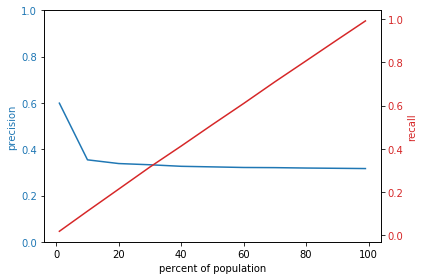

In [15]:
pp.plot_pct_pop(y_test,scores)

In [9]:
y_train['label'] = y_test
y_train['scores'] = scores

In [15]:
y_train.to_csv('test_results_lab8.csv')